<a href="https://colab.research.google.com/github/MichaelTRArruda/dados/blob/main/Serie_temporal_temperaturas_Recife.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<H1><B>Série temporal de temperaturas da cidade do Recife</B></H>
<H3>Arquivo contendo séries temporais de temperatura para a cidade do Recife. Os registros de temperatura são fornecidos por meses. As últimas colunas são valores médios de acordo com algumas estimativas de cálculo.<H3>
<H3><B>1 - Carregar a base de dados</B></H3>

In [28]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, classification_report

# Instalação das dependências
!pip install mlflow pyngrok xgboost -q

# Imports de MLFlow e utilidades para Colab
import mlflow
import mlflow.sklearn
import threading
import time
import os
from pyngrok import ngrok

# Classes de modelos e métricas que faltavam
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb # NEW!
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Configuração do MLFlow
mlflow.set_experiment("Previsao_Temperaturas_Recife_Colab")

url = "https://raw.githubusercontent.com/MichaelTRArruda/dados/refs/heads/main/station_recife.csv"

df = pd.read_csv(url)
df.replace(999.90, np.nan, inplace=True)
df = df.fillna(df.mean()).round(2)
df.rename(columns={'metANN': 'temperatura_media_anual'}, inplace=True)
df.head()

,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,D-J-F,M-A-M,J-J-A,S-O-N,temperatura_media_anual
0,1942,26.44,26.64,26.53,26.11,25.39,24.57,23.98,23.90,24.62,25.50,26.03,25.23,26.47,26.02,24.14,25.37,25.50
1,1943,25.73,25.73,26.03,24.83,24.03,23.23,22.33,22.53,23.43,24.73,25.13,25.52,25.56,24.96,22.70,24.43,24.41
2,1944,25.62,25.92,26.22,25.02,24.12,23.42,22.62,21.92,22.82,24.32,25.42,26.02,25.69,25.12,22.65,24.19,24.41
3,1945,26.52,25.52,26.52,25.82,24.32,22.72,22.32,23.02,23.82,24.52,25.52,25.41,26.02,25.55,22.69,24.62,24.72
4,1946,25.51,26.41,25.81,24.61,24.51,23.41,23.41,23.41,23.61,24.41,24.81,25.30,25.78,24.98,23.41,24.28,24.61


<H3><B>2 - Remove colunas vazias</B></H3>

In [22]:
print(df.isnull().sum())

#remove colunas com ao menos 70% de dados ausentes
df = df.dropna(thresh=0.7*len(df), axis=1)

YEAR                       0
JAN                        0
FEB                        0
MAR                        0
APR                        0
MAY                        0
JUN                        0
JUL                        0
AUG                        0
SEP                        0
OCT                        0
NOV                        0
DEC                        0
D-J-F                      0
M-A-M                      0
J-J-A                      0
S-O-N                      0
temperatura_media_anual    0
dtype: int64


<B><H3>3 - gráfico de linha para exibir as temperaturas médias anuais ao longo do tempo</B></H3>

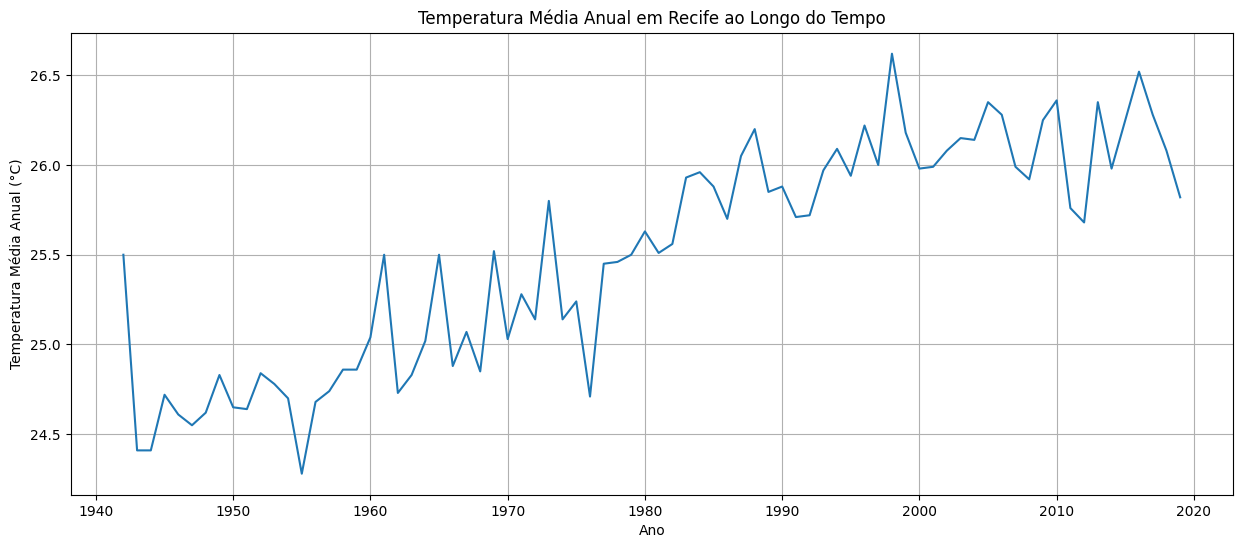

In [23]:
plt.figure(figsize=(15, 6))
plt.plot(df['YEAR'], df['temperatura_media_anual'])
plt.title('Temperatura Média Anual em Recife ao Longo do Tempo')
plt.xlabel('Ano')
plt.ylabel('Temperatura Média Anual (°C)')
plt.grid(True)
plt.show()

<B><H3>4 - Criando uma variável alvo categórica 'categoria_temperatura'</B></H3>

In [24]:
limiar_temp_baixa = df['temperatura_media_anual'].quantile(0.33)
limiar_temp_alta = df['temperatura_media_anual'].quantile(0.66)

def categorizar_temperatura(temp):
    if temp <= limiar_temp_baixa:
        return 'Baixa'
    elif temp >= limiar_temp_alta:
        return 'Alta'
    else:
        return 'Média'

df['categoria_temperatura'] = df['temperatura_media_anual'].apply(categorizar_temperatura)

<B><H3>5 - Definindo as características (features) e o alvo (target)</B></H3>

In [18]:
caracteristicas = df.drop(columns=['YEAR', 'temperatura_media_anual', 'categoria_temperatura'])
alvo = df['categoria_temperatura']

<B><H3>6 - Dividindo os dados em conjuntos de treino e teste</B></H3>

In [25]:
caracteristicas_treino, caracteristicas_teste, alvo_treino, alvo_teste = train_test_split(
    caracteristicas, alvo, test_size=0.3, random_state=42, stratify=alvo
)

print(df[['temperatura_media_anual', 'categoria_temperatura']].head())
print("\nDistribuição de 'categoria_temperatura' no conjunto de treino:")
print(alvo_treino.value_counts())

   temperatura_media_anual categoria_temperatura
0                    25.50                 Média
1                    24.41                 Baixa
2                    24.41                 Baixa
3                    24.72                 Baixa
4                    24.61                 Baixa

Distribuição de 'categoria_temperatura' no conjunto de treino:
categoria_temperatura
Alta     19
Baixa    18
Média    17
Name: count, dtype: int64


<B><H3>7 - Treinando e Avaliando Classificadores</B></H3>
<H3>Agora, vamos treinar os classificadores escolhidos (SVC, RandomForestClassifier e Perceptron) e avaliar seu desempenho usando acurácia e precisão como métricas. Também visualizaremos seus desempenhos usando matrizes de confusão.</H3>

2025/09/27 19:03:30 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



--- Treinamento e Avaliação do Modelo ---

Treinando SVC...


2025/09/27 19:03:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ MLFlow: SVC rastreado (Run ID: 831c966d11524a3998b2fd727f3f6cc4).
Acurácia do SVC: 0.9583
Precisão (Ponderada) do SVC: 0.9630


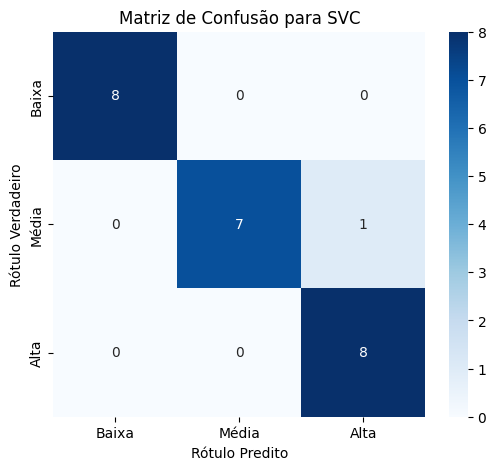


Relatório de Classificação para SVC:

              precision    recall  f1-score   support

        Alta       0.89      1.00      0.94         8
       Baixa       1.00      1.00      1.00         8
       Média       1.00      0.88      0.93         8

    accuracy                           0.96        24
   macro avg       0.96      0.96      0.96        24
weighted avg       0.96      0.96      0.96        24


Treinando RandomForestClassifier...


2025/09/27 19:03:37 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/27 19:03:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ MLFlow: RandomForestClassifier rastreado (Run ID: 18136eda92d3437193918c12750bde04).
Acurácia do RandomForestClassifier: 0.9167
Precisão (Ponderada) do RandomForestClassifier: 0.9333


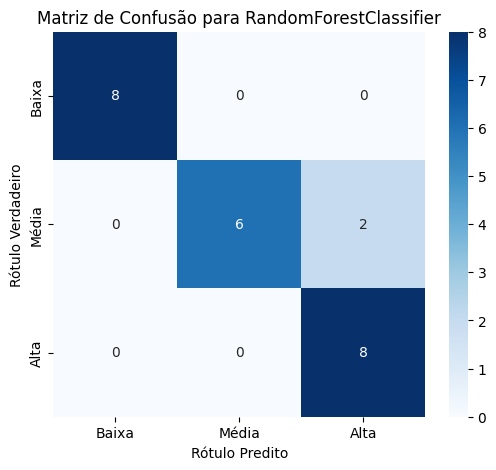


Relatório de Classificação para RandomForestClassifier:

              precision    recall  f1-score   support

        Alta       0.80      1.00      0.89         8
       Baixa       1.00      1.00      1.00         8
       Média       1.00      0.75      0.86         8

    accuracy                           0.92        24
   macro avg       0.93      0.92      0.92        24
weighted avg       0.93      0.92      0.92        24


Treinando Perceptron...


2025/09/27 19:03:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/27 19:03:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ MLFlow: Perceptron rastreado (Run ID: da8387c1d3e1444a819747e92461a504).
Acurácia do Perceptron: 0.3333
Precisão (Ponderada) do Perceptron: 0.1111


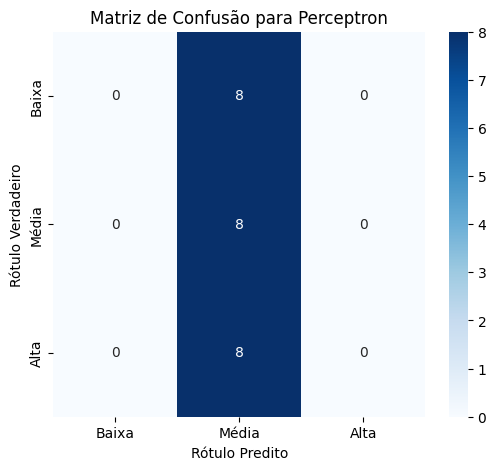


Relatório de Classificação para Perceptron:

              precision    recall  f1-score   support

        Alta       0.00      0.00      0.00         8
       Baixa       0.00      0.00      0.00         8
       Média       0.33      1.00      0.50         8

    accuracy                           0.33        24
   macro avg       0.11      0.33      0.17        24
weighted avg       0.11      0.33      0.17        24



In [29]:
modelo_svc = SVC(random_state=42)
modelo_rf = RandomForestClassifier(random_state=42)
modelo_perceptron = Perceptron(random_state=42)

classificadores = {
    'SVC': modelo_svc,
    'RandomForestClassifier': modelo_rf,
    'Perceptron': modelo_perceptron
}

resultados = {}

print("\n--- Treinamento e Avaliação do Modelo ---")
for nome, modelo in classificadores.items():

    # INÍCIO DO RASTREAMENTO MLFLOW
    with mlflow.start_run(run_name=nome) as run:

        # A) LOG DOS PARÂMETROS
        # Registra os hiperparâmetros (ex: random_state, C, kernel, etc.)
        mlflow.log_params(modelo.get_params())

        print(f"\nTreinando {nome}...")
        modelo.fit(caracteristicas_treino, alvo_treino)
        alvo_predito = modelo.predict(caracteristicas_teste)

        # Calcula as métricas
        acuracia = accuracy_score(alvo_teste, alvo_predito)
        precisao = precision_score(alvo_teste, alvo_predito, average='weighted', zero_division=0)

        # Opcional: Calcula o F1-Score (geralmente mais robusto que apenas Precisão)
        report = classification_report(alvo_teste, alvo_predito, output_dict=True, zero_division=0)
        f1_score_weighted = report['weighted avg']['f1-score'] # Variável adicional

        resultados[nome] = {'acuracia': acuracia, 'precisao': precisao}

        # B) LOG DAS MÉTRICAS
        mlflow.log_metric("Acuracia_Final", acuracia)
        mlflow.log_metric("Precisao_Ponderada", precisao)
        mlflow.log_metric("F1_Score_Ponderado", f1_score_weighted) # NEW! Logando F1

        # C) LOG DO MODELO TREINADO (Artefato)
        # Salva o modelo para que possa ser baixado e usado depois
        mlflow.sklearn.log_model(modelo, f"modelo_{nome.lower()}")

        print(f"✅ MLFlow: {nome} rastreado (Run ID: {run.info.run_id}).")

        # Imprime resultados no console
        print(f"Acurácia do {nome}: {acuracia:.4f}")
        print(f"Precisão (Ponderada) do {nome}: {precisao:.4f}")

        # Matriz de Confusão
        matriz_confusao = confusion_matrix(alvo_teste, alvo_predito, labels=['Baixa', 'Média', 'Alta'])
        plt.figure(figsize=(6, 5))
        sns.heatmap(matriz_confusao, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Baixa', 'Média', 'Alta'], yticklabels=['Baixa', 'Média', 'Alta'])
        plt.title(f'Matriz de Confusão para {nome}')
        plt.xlabel('Rótulo Predito')
        plt.ylabel('Rótulo Verdadeiro')
        plt.show()

        # Relatório de Classificação
        print(f"\nRelatório de Classificação para {nome}:\n")
        print(classification_report(alvo_teste, alvo_predito, zero_division=0))

<B><H3>8 - Comparação de Resultados</B></H3>

<H3>Vamos apresentar uma comparação clara dos scores de acurácia e precisão para cada modelo.</H3>



--- Comparação dos Modelos ---
                        acuracia  precisao
SVC                       0.9583    0.9630
RandomForestClassifier    0.9167    0.9333
Perceptron                0.3333    0.1111


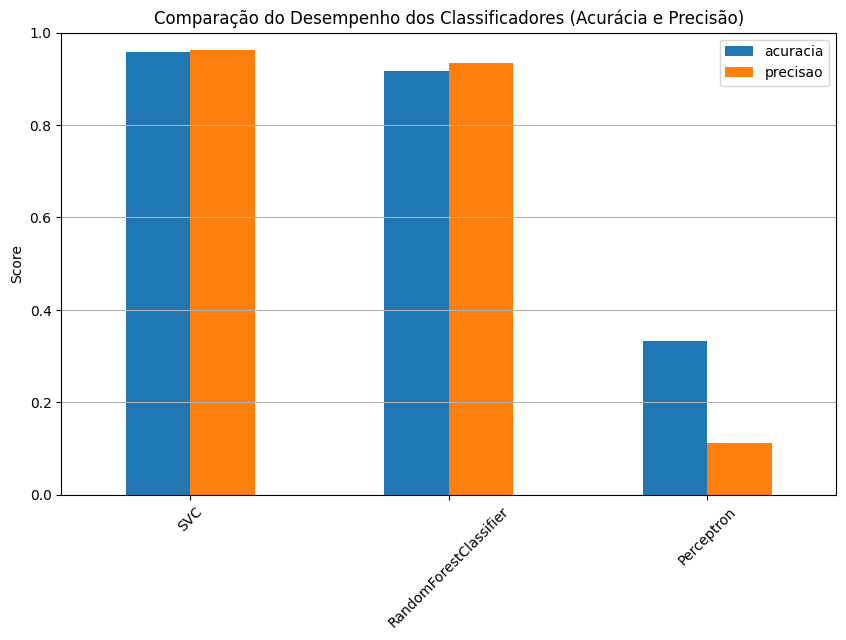

In [31]:
print("\n--- Comparação dos Modelos ---")
df_comparacao = pd.DataFrame(resultados).T
print(df_comparacao.round(4))

# Visualiza a comparação
df_comparacao.plot(kind='bar', figsize=(10, 6))
plt.title('Comparação do Desempenho dos Classificadores (Acurácia e Precisão)')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

**Diferentes Formas de Análise de Resultados**
Além da acurácia, precisão e matrizes de confusão, o **relatório de classificação** fornece um detalhamento de precisão, recall e F1-score para cada classe, o que é crucial para entender o desempenho do modelo em conjuntos de dados desbalanceados (se alguma de suas categorias de temperatura tiver significativamente menos amostras).

**1. Matriz de Confusão:** Como mostrado acima, uma matriz de confusão resume visualmente o desempenho de um algoritmo de classificação. Cada linha representa as instâncias em uma classe real, enquanto cada coluna representa as instâncias em uma classe predita. Isso ajuda a identificar onde o modelo está cometendo erros (por exemplo, confundindo "Baixa" com "Média").

**2. Relatório de Classificação:** Este relatório oferece um detalhamento por classe de:
* **Precisão:** A proporção de observações positivas corretamente preditas em relação a todas as predições positivas. Alta precisão indica uma baixa taxa de falsos positivos.
* **Recall (Sensibilidade):** A proporção de observações positivas corretamente preditas em relação a todos os positivos reais. Alto recall indica uma baixa taxa de falsos negativos.
* **F1-Score:** A média ponderada da Precisão e do Recall. É uma métrica útil quando você precisa equilibrar precisão e recall, especialmente com distribuição de classes desigual.
* **Suporte:** O número de ocorrências reais da classe no conjunto de dados especificado.

Ao examinar essas métricas, podemos obter uma compreensão mais profunda dos pontos fortes e fracos dos modelos. Por exemplo, um modelo pode ter alta acurácia geral, mas ter um desempenho ruim na previsão de uma categoria de temperatura específica.

In [34]:
# --- ÚLTIMA CÉLULA: INICIAR A UI DO MLFLOW (ACESSO VIA NGROK) ---

try:
    ngrok.set_auth_token("33IMfliEaQEel9oE5pJph8CWCtP_3vZEsSsrSvWb26PgP2p1A")
except Exception as e:
    print("ERRO: O token ngrok não foi configurado ou é inválido. O acesso pode falhar.")

# 1. Define o caminho de rastreamento local do Colab
tracking_uri = "file:///content/mlruns"
mlflow.set_tracking_uri(tracking_uri)

# 2. Função para rodar o servidor MLFlow em segundo plano
def run_mlflow_ui():
    # Isso inicia o servidor na porta 5000 (padrão)
    os.system("mlflow ui --port 5000")

print("Iniciando servidor MLFlow...")
# Inicia o servidor em uma thread separada para não bloquear o notebook
threading.Thread(target=run_mlflow_ui, daemon=True).start()
time.sleep(5) # Espera 5 segundos para o servidor iniciar

# 3. Cria o túnel público (link) com ngrok
try:
    public_url = ngrok.connect(addr="5000", proto="http")

    print("\n" + "="*70)
    print("OK! MLFLOW UI ESTÁ DISPONÍVEL NESTE LINK:")
    print(public_url)
    print("="*70 + "\n")

except Exception as e:
    print(f"ERRO FATAL ao criar o túnel ngrok. Verifique se o token foi configurado: {e}")

# Mantenha esta célula em execução (com o ícone de 'play' ativo) para que o link ngrok funcione no navegador.

Iniciando servidor MLFlow...

✅ MLFLOW UI ESTÁ DISPONÍVEL NESTE LINK:
NgrokTunnel: "https://kian-unabating-kyleigh.ngrok-free.dev" -> "http://localhost:5000"

